In [1]:
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.sampling.sampling import LogicSampler

a = BbnNode(Variable(0, 'a', ['on', 'off']), [0.5, 0.5])
b = BbnNode(Variable(1, 'b', ['on', 'off']), [0.5, 0.5, 0.4, 0.6])
c = BbnNode(Variable(2, 'c', ['on', 'off']), [0.7, 0.3, 0.2, 0.8])

bbn = Bbn() \
    .add_node(a) \
    .add_node(b) \
    .add_node(c) \
    .add_edge(Edge(a, b, EdgeType.DIRECTED)) \
    .add_edge(Edge(b, c, EdgeType.DIRECTED))

sampler = LogicSampler(bbn)
samples = sampler.get_samples(n_samples=10000, seed=37)

In [2]:
import pandas as pd

i2n = {n.variable.id: n.variable.name for n in  bbn.get_nodes()}
samples = pd.DataFrame(samples).rename(columns=i2n)

In [3]:
def get_profile(df):
    profile = {}
    for c in df.columns:
        values = sorted(list(df[c].value_counts().index))
        profile[c] = values
    return profile

n2v = {n.variable.name: sorted(n.variable.values) for n in  bbn.get_nodes()}
n2v = get_profile(samples)
n2v

{'a': ['off', 'on'], 'b': ['off', 'on'], 'c': ['off', 'on']}

In [4]:
samples.shape

(10000, 3)

In [5]:
samples.head()

,a,b,c
0,off,off,on
1,off,off,off
2,on,off,off
3,off,off,off
4,on,off,off


In [6]:
parents = {
    'a': [],
    'b': ['a'],
    'c': ['b']
}

In [7]:
import networkx as nx
from networkx.algorithms.dag import topological_sort

def get_n2i(parents):
    g = nx.DiGraph()
    for k in parents:
        g.add_node(k)
    for ch, pas in parents.items():
        for pa in pas:
            g.add_edge(pa, ch)
    nodes = list(topological_sort(g))
    return {n:i for i, n in enumerate(nodes)}

n2i = get_n2i(parents)
n2i

{'a': 0, 'b': 1, 'c': 2}

In [8]:
from itertools import product

def get_cpt(name, parents, n2v, df):
    parents = sorted(parents)
    n2v = {k: sorted(v) for k, v in n2v.items()}
    
    n = df.shape[0]
    
    cpts = []
    if len(parents) == 0:
        for v in n2v[name]:
            c = df[df[name] == v].shape[0]
            p = c / n
            cpts.append(p)
    else:
        domains = [(n, d) for n, d in n2v.items() if n in parents]
        domains = sorted(domains, key=lambda tup: tup[0])
        domain_names = [tup[0] for tup in domains]
        domain_values = [tup[1] for tup in domains]
        domains = list(product(*domain_values))
        
        for values in domains:
            probs = []
            denom_q = ' and '.join([f'{n}=="{v}"' for n, v in zip(domain_names, values)])
            for v in n2v[name]:
                numer_q = f'{name}=="{v}" and {denom_q}'
            
                numer = df.query(numer_q).shape[0] / n
                denom = df.query(denom_q).shape[0] / n
                prob = numer / denom
                probs.append(prob)
            probs = pd.Series(probs)
            probs = probs / probs.sum()
            probs = list(probs)
            cpts.extend(probs)
        
    return cpts

print(get_cpt('a', parents['a'], n2v, samples))
print(get_cpt('b', parents['b'], n2v, samples))
print(get_cpt('c', parents['c'], n2v, samples))

[0.4985, 0.5015]
[0.6082246740220663, 0.3917753259779338, 0.4925224327018943, 0.5074775672981057]
[0.7928026172300982, 0.20719738276990188, 0.302134281903068, 0.697865718096932]


In [9]:
def get_bbn(parents, df):
    n2v = get_profile(df)
    n2i = get_n2i(df)
    n2c = {n: get_cpt(n, parents[n], n2v, df) for n in parents}
    
    bbn = Bbn()
    
    nodes = {}
    for name in n2v:
        idx = n2i[name]
        values = n2v[name]
        cpts = n2c[name]
        
        v = Variable(idx, name, values)
        node = BbnNode(v, cpts)
        nodes[name] = node
        bbn.add_node(node)
        
    for ch, parents in parents.items():
        ch_node = nodes[ch]
        for pa in parents:
            pa_node = nodes[pa]
            
            edge = Edge(pa_node, ch_node, EdgeType.DIRECTED)
            bbn.add_edge(edge)
        
    return bbn
        
    
bbn1 = get_bbn(parents, samples)

In [10]:
n, d = bbn1.to_nx_graph()

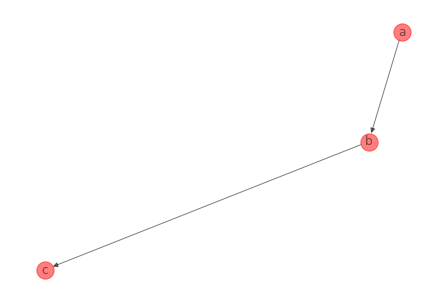

In [11]:
nx.draw(n, with_labels=True, labels=d, node_color='r', alpha=0.5)

In [12]:
from pybbn.pptc.inferencecontroller import InferenceController

join_tree = InferenceController.apply(bbn)

# print the posterior probabilities
for node, posteriors in join_tree.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

b : on=0.45000, off=0.55000
a : on=0.50000, off=0.50000
c : on=0.42500, off=0.57500


In [13]:
from pybbn.pptc.inferencecontroller import InferenceController

join_tree1 = InferenceController.apply(bbn1)

# print the posterior probabilities
for node, posteriors in join_tree1.get_posteriors().items():
    p = ', '.join([f'{val}={prob:.5f}' for val, prob in posteriors.items()])
    print(f'{node} : {p}')

b : off=0.55020, on=0.44980
c : off=0.57210, on=0.42790
a : off=0.49850, on=0.50150
